In [19]:
import scanpy as sc


files = {
    "pbmc_3p": "data/processed/pbmc_3p_clean_qc.h5ad",
    "pbmc_5p": "data/processed/pbmc_5p_clean_qc.h5ad",
    "cd4t":    "data/processed/cd4t_qc.h5ad",
    "cd8t_d1": "data/processed/cd8t_d1_qc.h5ad",
    "nk":      "data/processed/nk_qc.h5ad",
    "gdt":     "data/processed/gdt_3donors_qc.h5ad",
}
# load processed datasets
adatas = {}
for f in files:
    adata = sc.read_h5ad(files[f])
    adatas[f] = adata
    print(f"{f}: {adata.n_obs} cells, {adata.n_vars} genes")

pbmc_3p: 1053 cells, 13945 genes
pbmc_5p: 815 cells, 13511 genes
cd4t: 11209 cells, 13580 genes
cd8t_d1: 38364 cells, 20079 genes
nk: 8355 cells, 13757 genes
cd8t_d1: 38364 cells, 20079 genes
nk: 8355 cells, 13757 genes
gdt: 8163 cells, 16295 genes
gdt: 8163 cells, 16295 genes


In [32]:
# Concatenate all datasets
adata_all = sc.concat(adatas.values(), label="dataset", keys=adatas.keys())

print("Original cell counts per celltype:")
print(adata_all.obs["celltype"].value_counts())

# Downsize celltypes: cap at 900 cells, keep as-is if below 900
celltypes = adata_all.obs["celltype"].unique().tolist()
max_cells = 900

# Subsample each celltype
subsampled_adatas = []
for celltype in celltypes:
    adata_ct = adata_all[adata_all.obs["celltype"] == celltype].copy()
    n_cells = adata_ct.n_obs
    
    if n_cells > max_cells:
        sc.pp.subsample(adata_ct, n_obs=max_cells, random_state=42)
    
    subsampled_adatas.append(adata_ct)

# Concatenate all subsampled celltypes
adata_all = sc.concat(subsampled_adatas)

print("\nFinal cell counts per celltype:")
print(adata_all.obs["celltype"].value_counts())

# Normalize and log-transform the combined dataset
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)

t:\Downloads\CompMed\compmed_env\Lib\site-packages\anndata\_core\anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
t:\Downloads\CompMed\compmed_env\Lib\site-packages\anndata\_core\anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
t:\Downloads\CompMed\compmed_env\Lib\site-packages\anndata\_core\anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Original cell counts per celltype:
celltype
CD8 T cell                     38364
CD4 T cell                     11209
Natural killer cell             8355
GDT                             8163
CD14+ monocyte                   868
B cell                           657
CD16+ monocyte                   173
Dendritic cell                    85
Megakaryocyte                     47
Plasmacytoid dendritic cell       38
Name: count, dtype: int64

Final cell counts per celltype:
celltype
CD4 T cell                     900
CD8 T cell                     900
Natural killer cell            900
GDT                            900
CD14+ monocyte                 868
B cell                         657
CD16+ monocyte                 173
Dendritic cell                  85
Megakaryocyte                   47
Plasmacytoid dendritic cell     38
Name: count, dtype: int64

Final cell counts per celltype:
celltype
CD4 T cell                     900
CD8 T cell                     900
Natural killer cell           

t:\Downloads\CompMed\compmed_env\Lib\site-packages\anndata\_core\anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [29]:
# HVG and scaling + PCA
sc.pp.highly_variable_genes(adata_all, n_top_genes=2000, subset=True, flavor="seurat_v3")
sc.pp.scale(adata_all, max_value=10)
sc.tl.pca(adata_all, svd_solver="arpack")

t:\Downloads\CompMed\compmed_env\Lib\site-packages\legacy_api_wrap\__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
t:\Downloads\CompMed\compmed_env\Lib\site-packages\anndata\_core\anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\vnmt1\miniconda3\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [ ]:
# Harmony integration
print("Running Harmony integration...")
sc.external.pp.harmony_integrate(adata_all, key="dataset")

# Check if Harmony integration created the expected key
print("\nAvailable obsm keys after Harmony:")
print(adata_all.obsm.keys())

# Verify X_pca_harmony exists
if "X_pca_harmony" in adata_all.obsm:
    print(f"✓ X_pca_harmony created with shape: {adata_all.obsm['X_pca_harmony'].shape}")
else:
    print("✗ X_pca_harmony not found!")

# Continue with downstream analysis
sc.pp.neighbors(adata_all, use_rep="X_pca_harmony")
sc.tl.umap(adata_all)
sc.tl.leiden(adata_all, resolution=0.5)

2025-11-25 02:37:00,317 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-25 02:37:00,611 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-25 02:37:00,635 - harmonypy - INFO - Iteration 1 of 10
2025-11-25 02:37:00,611 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-25 02:37:00,635 - harmonypy - INFO - Iteration 1 of 10
2025-11-25 02:37:01,112 - harmonypy - INFO - Iteration 2 of 10
2025-11-25 02:37:01,112 - harmonypy - INFO - Iteration 2 of 10
2025-11-25 02:37:01,605 - harmonypy - INFO - Converged after 2 iterations
2025-11-25 02:37:01,605 - harmonypy - INFO - Converged after 2 iterations


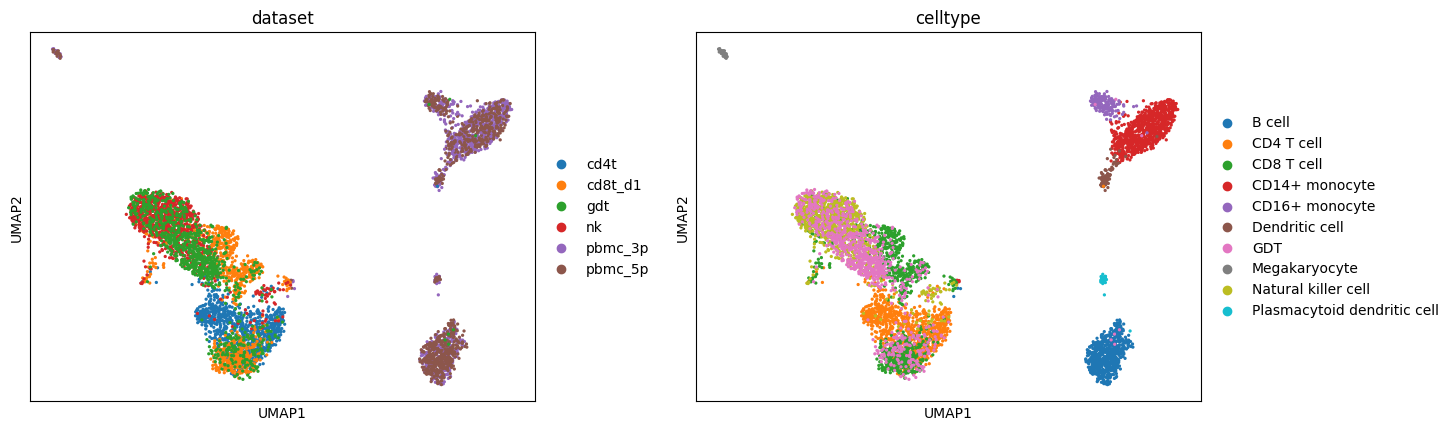

In [31]:
# Plot UMAP colored by dataset and clusters
sc.pl.umap(adata_all, color=["dataset", "celltype"], wspace=0.2)

In [33]:
# Add binary label
adata.obs["is_gdt"] = (adata.obs["celltype"] == "GDT").astype(int)

### Export training data

In [35]:
import pandas as pd
import numpy as np


# feature matrix from Harmony PCs
X = adata_all.obsm["X_pca_harmony"]

# make a DataFrame with cell barcodes as index
pc_names = [f"PC{i+1}" for i in range(X.shape[1])]
X_df = pd.DataFrame(X, index=adata_all.obs_names, columns=pc_names)

# labels
y_df = adata_all.obs[["celltype"]].copy()
# Add binary label for GDT
y_df["is_gdt"] = (y_df["celltype"] == "GDT").astype(int)
y_df.index.name = "cell_id"

# Check X and y
print(X_df.head())
print(y_df.head())

KeyError: 'X_pca_harmony'

In [ ]:
# write to disk (compressed csv)
X_df.to_csv("gdt_X_pca_harmony.csv.gz")
y_df.to_csv("gdt_y_labels.csv.gz")

### Code to read data

In [ ]:
X = pd.read_csv("gdt_X_pca_harmony.csv.gz", index_col=0).values
y = pd.read_csv("gdt_y_labels.csv.gz", index_col=0)["is_gdt"].values
# Or if want to use multiclass
y = pd.read_csv("gdt_y_labels.csv.gz", index_col=0)["celltype"].values